# 3D Multi-class Segmentation with UNETR  (Muscle, Fat (subcut and internal), psoas,Cavity,BGD)

## Setup environment

In [1]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

print_config()

MONAI version: 0.10.dev2231
Numpy version: 1.23.1
Pytorch version: 1.12.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 8236821c099e5997f7ad0410c5374e4472f4ed14
MONAI __file__: /home/adminbthomas/miniconda3/envs/PT02/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.9
Nibabel version: 4.0.1
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: 2.9.1
gdown version: 4.5.1
TorchVision version: 0.13.0+cu102
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.1
pandas version: 1.4.3
einops version: 0.4.1
transformers version: 4.20.1
mlflow version: 1.27.0
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [3]:
# directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = "/home/adminbthomas/Downloads/ensemble/unetr"# root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/home/adminbthomas/Downloads/ensemble/unetr


## Setup transforms for training and validation

In [4]:
import datetime
import time

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
#         AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 1.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=0,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=False,   # change-intermedouts 
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        ToTensord(keys=["image", "label"]),
#         SaveImaged(keys="image", meta_keys="image_meta_dict", output_dir="./outMR02_Jul23_Interinputs", output_postfix=datetime.datetime.now().strftime('%f'), resample=False, separate_folder=False),
#         SaveImaged(keys="label", meta_keys="label_meta_dict", output_dir="./outMR02_Jul23_Interinputs", output_postfix=datetime.datetime.now().strftime('%f'), resample=False, separate_folder=False),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
#         AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 1.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=250, b_min=0.0, b_max=1.0, clip=False
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

### DATA

In [5]:
data_dir = os.path.join(root_dir,"data/")

In [6]:
# data_dir = os.path.join(root_dir,"013123_MR/")
split_JSON = "dataset_MR09fold4.json"
datasets = data_dir + split_JSON
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True
)
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4
)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
)

Modifying image pixdim from [1.4648438 1.4648438 4.        0.       ] to [  1.46484375   1.46484375   4.         268.45717811]
Loading dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.64it/s]


## Check data shape and visualize

image shape: torch.Size([1, 250, 176, 97]), label shape: torch.Size([1, 250, 176, 97])


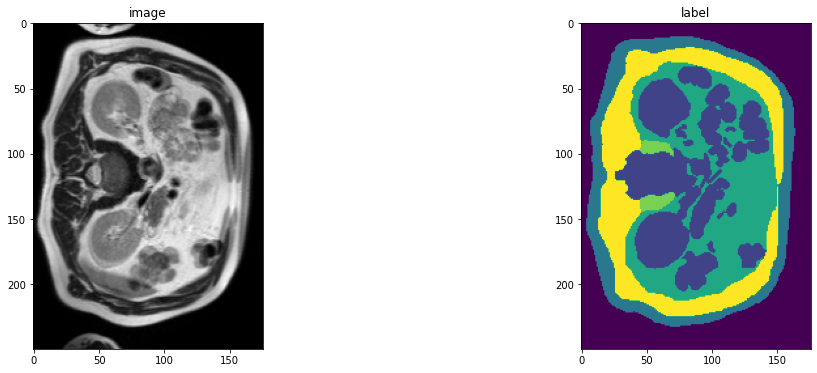

In [7]:
slice_map = {
    "A024_v1_T2W.nii.gz": 10,
    "A024_v1_T2W.nii.gz": 8,
    "A024_v1_T2W.nii.gz": 6
}
case_num = 1
img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

### Create Model, Loss, Optimizer


In [8]:
#### os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda:1")

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=6,
    feature_size=12,
    use_checkpoint=True,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

### Execute a typical PyTorch training process

In [9]:
def validation(epoch_iterator_val):
    model.eval()
    dice_vals = list()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].to(device), batch["label"].to(device))
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice = dice_metric.aggregate().item()
            dice_vals.append(dice)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps) (dice=%2.5f)" % (global_step, 10.0, dice)
            )
        dice_metric.reset()
    mean_dice_val = np.mean(dice_vals)
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].to(device), batch["label"].to(device))
#         print(x.shape)
#         print(y.shape)
#         plt.figure("image", (18, 6))
#         plt.subplot(1, 2, 1)
#         plt.title("image")
#         plt.imshow(x[3,0,:,:,4].detach().cpu(), cmap="gray")
#         plt.subplot(1, 2, 2)
#         plt.title("label")
#         plt.imshow(y[3,0,:,:,4].detach().cpu())
#         plt.show()
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(data_dir, "TestMR10_swinUNetR_fold4.pth")
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
        
    return global_step, dice_val_best, global_step_best


max_iterations = 70000
eval_num = 250
post_label = AsDiscrete(to_onehot=6)
post_pred = AsDiscrete(argmax=True, to_onehot=6)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
#     print('I am waiting....')
#     time.sleep(1)
model.load_state_dict(torch.load(os.path.join(data_dir, "TestMR10_swinUNetR_fold4.pth")))

Validate (X / X Steps) (dice=X.X):   0%|                                                                                                                                      | 0/3 [00:00<?, ?it/s]None of the inputs have requires_grad=True. Gradients will be None

Training (250 / 70000 Steps) (loss=1.94640):  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 11/12 [00:15<00:02,  2.40s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5993099610010783 Current Avg. Dice: 0.5993099610010783


Training (500 / 70000 Steps) (loss=1.37154):  75%|██████████████████████████████████████████████████████████████████████████████████████▎                            | 9/12 [00:13<00:07,  2.42s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6543217698733012 Current Avg. Dice: 0.6543217698733012


Training (750 / 70000 Steps) (loss=1.25220):  58%|███████████████████████████████████████████████████████████████████                                                | 7/12 [00:11<00:12,  2.51s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6822385986646017 Current Avg. Dice: 0.6822385986646017


Training (1000 / 70000 Steps) (loss=1.05151):  42%|███████████████████████████████████████████████▌                                                                  | 5/12 [00:10<00:19,  2.75s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6995945572853088 Current Avg. Dice: 0.6995945572853088


Training (1250 / 70000 Steps) (loss=1.00096):  25%|████████████████████████████▌                                                                                     | 3/12 [00:08<00:30,  3.34s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7056123812993368 Current Avg. Dice: 0.7056123812993368


Training (1500 / 70000 Steps) (loss=0.84045):   8%|█████████▌                                                                                                        | 1/12 [00:06<01:12,  6.58s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7135494550069174 Current Avg. Dice: 0.7135494550069174


Training (1750 / 70000 Steps) (loss=0.79023):  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 11/12 [00:15<00:02,  2.40s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7157893776893616 Current Avg. Dice: 0.7157893776893616


Training (2000 / 70000 Steps) (loss=1.79687):  75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 9/12 [00:13<00:07,  2.42s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7252458532651266 Current Avg. Dice: 0.7252458532651266


Training (2250 / 70000 Steps) (loss=0.89419):  58%|██████████████████████████████████████████████████████████████████▌                                               | 7/12 [00:11<00:12,  2.51s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7332893013954163 Current Avg. Dice: 0.7332893013954163


Training (2500 / 70000 Steps) (loss=0.59671):  42%|███████████████████████████████████████████████▌                                                                  | 5/12 [00:09<00:18,  2.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7332893013954163 Current Avg. Dice: 0.7292972803115845


Training (2750 / 70000 Steps) (loss=0.96899):  25%|████████████████████████████▌                                                                                     | 3/12 [00:08<00:29,  3.31s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7332893013954163 Current Avg. Dice: 0.7236545085906982


Training (3000 / 70000 Steps) (loss=0.57741):   8%|█████████▌                                                                                                        | 1/12 [00:06<01:14,  6.77s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7332893013954163 Current Avg. Dice: 0.7311858336130778


Training (3250 / 70000 Steps) (loss=0.63971):  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 11/12 [00:14<00:02,  2.36s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7332893013954163 Current Avg. Dice: 0.7316675384839376


Training (3500 / 70000 Steps) (loss=1.05991):  75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 9/12 [00:13<00:07,  2.43s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7385800083478292 Current Avg. Dice: 0.7385800083478292


Training (3750 / 70000 Steps) (loss=0.56956):  58%|██████████████████████████████████████████████████████████████████▌                                               | 7/12 [00:11<00:12,  2.49s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7385800083478292 Current Avg. Dice: 0.7381940484046936


Training (4000 / 70000 Steps) (loss=0.78644):  42%|███████████████████████████████████████████████▌                                                                  | 5/12 [00:10<00:19,  2.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7385800083478292 Current Avg. Dice: 0.7350421746571859


Training (4250 / 70000 Steps) (loss=0.51204):  25%|████████████████████████████▌                                                                                     | 3/12 [00:08<00:30,  3.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7385800083478292 Current Avg. Dice: 0.7314372658729553


Training (4500 / 70000 Steps) (loss=0.55176):   8%|█████████▌                                                                                                        | 1/12 [00:06<01:14,  6.75s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7416357199350992 Current Avg. Dice: 0.7416357199350992


Training (4750 / 70000 Steps) (loss=0.49446):  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 11/12 [00:14<00:02,  2.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7416357199350992 Current Avg. Dice: 0.7407702803611755


Training (5000 / 70000 Steps) (loss=0.48004):  75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 9/12 [00:13<00:07,  2.44s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7440410852432251 Current Avg. Dice: 0.7440410852432251


Training (5250 / 70000 Steps) (loss=0.48937):  58%|██████████████████████████████████████████████████████████████████▌                                               | 7/12 [00:11<00:12,  2.54s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7463371753692627 Current Avg. Dice: 0.7463371753692627


Training (5500 / 70000 Steps) (loss=0.81290):  42%|███████████████████████████████████████████████▌                                                                  | 5/12 [00:10<00:19,  2.73s/it]

Model Was Saved ! Current Best Avg. Dice: 0.747421662012736 Current Avg. Dice: 0.747421662012736


Training (5750 / 70000 Steps) (loss=0.79167):  25%|████████████████████████████▌                                                                                     | 3/12 [00:08<00:29,  3.32s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.747421662012736 Current Avg. Dice: 0.7471782763799032


Training (6000 / 70000 Steps) (loss=0.51703):   8%|█████████▌                                                                                                        | 1/12 [00:06<01:13,  6.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.747421662012736 Current Avg. Dice: 0.7421913345654806


Training (6250 / 70000 Steps) (loss=0.53832):  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 11/12 [00:15<00:02,  2.36s/it]

Model Was Saved ! Current Best Avg. Dice: 0.751136839389801 Current Avg. Dice: 0.751136839389801


Training (6500 / 70000 Steps) (loss=0.49213):  75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 9/12 [00:13<00:07,  2.42s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.751136839389801 Current Avg. Dice: 0.7468258341153463


Training (6750 / 70000 Steps) (loss=0.50528):  58%|██████████████████████████████████████████████████████████████████▌                                               | 7/12 [00:11<00:12,  2.52s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7514568567276001 Current Avg. Dice: 0.7514568567276001


Training (7000 / 70000 Steps) (loss=0.51293):  42%|███████████████████████████████████████████████▌                                                                  | 5/12 [00:10<00:19,  2.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7514568567276001 Current Avg. Dice: 0.7511229515075684


Training (7250 / 70000 Steps) (loss=0.56685):  25%|████████████████████████████▌                                                                                     | 3/12 [00:08<00:30,  3.35s/it]

Model Was Saved ! Current Best Avg. Dice: 0.751751184463501 Current Avg. Dice: 0.751751184463501


Training (7500 / 70000 Steps) (loss=0.66025):   8%|█████████▌                                                                                                        | 1/12 [00:06<01:14,  6.78s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.751751184463501 Current Avg. Dice: 0.7515360116958618


Training (7750 / 70000 Steps) (loss=0.66873):  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 11/12 [00:14<00:02,  2.39s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7537782788276672 Current Avg. Dice: 0.7537782788276672


Training (8000 / 70000 Steps) (loss=0.37751):  75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 9/12 [00:13<00:07,  2.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7537782788276672 Current Avg. Dice: 0.7535703579584757


Training (8250 / 70000 Steps) (loss=0.42360):  58%|██████████████████████████████████████████████████████████████████▌                                               | 7/12 [00:11<00:12,  2.52s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8550328016281128 Current Avg. Dice: 0.8550328016281128


Training (8500 / 70000 Steps) (loss=0.39473):  42%|███████████████████████████████████████████████▌                                                                  | 5/12 [00:10<00:19,  2.73s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8838709791501363 Current Avg. Dice: 0.8838709791501363


Training (8750 / 70000 Steps) (loss=0.50290):  25%|████████████████████████████▌                                                                                     | 3/12 [00:08<00:30,  3.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8838709791501363 Current Avg. Dice: 0.8770938913027445


Training (9000 / 70000 Steps) (loss=0.45095):   8%|█████████▌                                                                                                        | 1/12 [00:06<01:12,  6.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8838709791501363 Current Avg. Dice: 0.8777144352595011


Training (9250 / 70000 Steps) (loss=0.32648):  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 11/12 [00:14<00:02,  2.38s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8879187305768331 Current Avg. Dice: 0.8879187305768331


Training (9500 / 70000 Steps) (loss=0.46367):  75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 9/12 [00:13<00:07,  2.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8879187305768331 Current Avg. Dice: 0.8856651782989502


Training (9750 / 70000 Steps) (loss=0.39365):  58%|██████████████████████████████████████████████████████████████████▌                                               | 7/12 [00:11<00:12,  2.50s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8879187305768331 Current Avg. Dice: 0.8794955213864645


Training (10000 / 70000 Steps) (loss=0.40943):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:19,  2.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8879187305768331 Current Avg. Dice: 0.883433202902476


Training (10250 / 70000 Steps) (loss=0.41441):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.32s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8879187305768331 Current Avg. Dice: 0.8838550845781962


Training (10500 / 70000 Steps) (loss=0.26741):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:12,  6.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8879187305768331 Current Avg. Dice: 0.8839268287022909


Training (10750 / 70000 Steps) (loss=0.34702):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.38s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8879187305768331 Current Avg. Dice: 0.885760227839152


Training (11000 / 70000 Steps) (loss=0.37843):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.43s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8902491927146912 Current Avg. Dice: 0.8902491927146912


Training (11250 / 70000 Steps) (loss=0.36117):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.53s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8926021456718445 Current Avg. Dice: 0.8926021456718445


Training (11500 / 70000 Steps) (loss=0.29543):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:19,  2.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8926021456718445 Current Avg. Dice: 0.8848181764284769


Training (11750 / 70000 Steps) (loss=0.38255):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.28s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8926021456718445 Current Avg. Dice: 0.888765811920166


Training (12000 / 70000 Steps) (loss=0.37370):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:12,  6.57s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8926021456718445 Current Avg. Dice: 0.8893877863883972


Training (12250 / 70000 Steps) (loss=0.49014):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8926021456718445 Current Avg. Dice: 0.8859277168909708


Training (12500 / 70000 Steps) (loss=0.26437):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.45s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8929710984230042 Current Avg. Dice: 0.8929710984230042


Training (12750 / 70000 Steps) (loss=0.47811):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.49s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8929710984230042 Current Avg. Dice: 0.8905807336171468


Training (13000 / 70000 Steps) (loss=0.40553):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:19,  2.75s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8950179219245911 Current Avg. Dice: 0.8950179219245911


Training (13250 / 70000 Steps) (loss=0.37212):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.29s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8950179219245911 Current Avg. Dice: 0.8834846019744873


Training (13500 / 70000 Steps) (loss=0.26449):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:13,  6.70s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8950179219245911 Current Avg. Dice: 0.8896372516949972


Training (13750 / 70000 Steps) (loss=0.33282):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8950179219245911 Current Avg. Dice: 0.888154129187266


Training (14000 / 70000 Steps) (loss=0.33013):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.43s/it]

Model Was Saved ! Current Best Avg. Dice: 0.895827054977417 Current Avg. Dice: 0.895827054977417


Training (14250 / 70000 Steps) (loss=0.43568):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.51s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.895827054977417 Current Avg. Dice: 0.8947743972142538


Training (14500 / 70000 Steps) (loss=0.51879):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:19,  2.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.895827054977417 Current Avg. Dice: 0.8927985231081644


Training (14750 / 70000 Steps) (loss=0.31553):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:30,  3.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.895827054977417 Current Avg. Dice: 0.8952312270800272


Training (15000 / 70000 Steps) (loss=0.29176):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:15,  6.82s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8968302806218466 Current Avg. Dice: 0.8968302806218466


Training (15250 / 70000 Steps) (loss=0.30546):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.36s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8968302806218466 Current Avg. Dice: 0.8870167930920919


Training (15500 / 70000 Steps) (loss=0.28947):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.41s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8968302806218466 Current Avg. Dice: 0.8944061199824015


Training (15750 / 70000 Steps) (loss=0.30103):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.50s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8968302806218466 Current Avg. Dice: 0.8936003049214681


Training (16000 / 70000 Steps) (loss=0.25705):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8968302806218466 Current Avg. Dice: 0.8957587480545044


Training (16250 / 70000 Steps) (loss=0.23639):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.29s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8968302806218466 Current Avg. Dice: 0.8957654237747192


Training (16500 / 70000 Steps) (loss=0.36800):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:15,  6.86s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8968302806218466 Current Avg. Dice: 0.8955013155937195


Training (16750 / 70000 Steps) (loss=0.28051):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.38s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8968302806218466 Current Avg. Dice: 0.8953876694043478


Training (17000 / 70000 Steps) (loss=0.28496):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8968302806218466 Current Avg. Dice: 0.8901544809341431


Training (17250 / 70000 Steps) (loss=0.38732):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.49s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8968302806218466 Current Avg. Dice: 0.8916674455006918


Training (17500 / 70000 Steps) (loss=0.33420):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:19,  2.74s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8977256615956625 Current Avg. Dice: 0.8977256615956625


Training (17750 / 70000 Steps) (loss=0.27318):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.31s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8977256615956625 Current Avg. Dice: 0.8907666802406311


Training (18000 / 70000 Steps) (loss=0.30692):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:13,  6.69s/it]

Model Was Saved ! Current Best Avg. Dice: 0.899916927019755 Current Avg. Dice: 0.899916927019755


Training (18250 / 70000 Steps) (loss=0.26904):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.899916927019755 Current Avg. Dice: 0.8991811474164327


Training (18500 / 70000 Steps) (loss=0.30099):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.43s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.899916927019755 Current Avg. Dice: 0.8979583978652954


Training (18750 / 70000 Steps) (loss=0.29975):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.49s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.899916927019755 Current Avg. Dice: 0.894577145576477


Training (19000 / 70000 Steps) (loss=0.55032):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:19,  2.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.899916927019755 Current Avg. Dice: 0.8941050171852112


Training (19250 / 70000 Steps) (loss=0.30901):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.30s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.899916927019755 Current Avg. Dice: 0.8939180572827657


Training (19500 / 70000 Steps) (loss=0.24739):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:12,  6.62s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.899916927019755 Current Avg. Dice: 0.8952088753382365


Training (19750 / 70000 Steps) (loss=0.24794):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.899916927019755 Current Avg. Dice: 0.8994062542915344


Training (20000 / 70000 Steps) (loss=0.44923):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.39s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.899916927019755 Current Avg. Dice: 0.8928235967954


Training (20250 / 70000 Steps) (loss=0.23466):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.48s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.899916927019755 Current Avg. Dice: 0.8974770704905192


Training (20500 / 70000 Steps) (loss=0.27980):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.899916927019755 Current Avg. Dice: 0.8983576496442159


Training (20750 / 70000 Steps) (loss=0.62048):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.27s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.899916927019755 Current Avg. Dice: 0.8971527218818665


Training (21000 / 70000 Steps) (loss=0.46430):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:12,  6.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.899916927019755 Current Avg. Dice: 0.8987125754356384


Training (21250 / 70000 Steps) (loss=0.28761):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.37s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9002737402915955 Current Avg. Dice: 0.9002737402915955


Training (21500 / 70000 Steps) (loss=0.26715):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.38s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9002737402915955 Current Avg. Dice: 0.8997751673062643


Training (21750 / 70000 Steps) (loss=0.22715):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.49s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9002737402915955 Current Avg. Dice: 0.8945405085881551


Training (22000 / 70000 Steps) (loss=0.36498):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9002737402915955 Current Avg. Dice: 0.89672323067983


Training (22250 / 70000 Steps) (loss=0.40951):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.31s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9002737402915955 Current Avg. Dice: 0.8990198572476705


Training (22500 / 70000 Steps) (loss=0.26617):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:12,  6.59s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9008494814236959 Current Avg. Dice: 0.9008494814236959


Training (22750 / 70000 Steps) (loss=0.38828):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9008494814236959 Current Avg. Dice: 0.8968997200330099


Training (23000 / 70000 Steps) (loss=0.25961):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.39s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9008494814236959 Current Avg. Dice: 0.8981116016705831


Training (23250 / 70000 Steps) (loss=0.25266):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.49s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9008494814236959 Current Avg. Dice: 0.8991657098134359


Training (23500 / 70000 Steps) (loss=0.31831):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.70s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9008494814236959 Current Avg. Dice: 0.897946298122406


Training (23750 / 70000 Steps) (loss=0.29288):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.31s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9008494814236959 Current Avg. Dice: 0.9005741079648336


Training (24000 / 70000 Steps) (loss=0.25932):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:15,  6.87s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9019175966580709 Current Avg. Dice: 0.9019175966580709


Training (24250 / 70000 Steps) (loss=0.33719):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.38s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9019175966580709 Current Avg. Dice: 0.9006571173667908


Training (24500 / 70000 Steps) (loss=0.48429):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9019175966580709 Current Avg. Dice: 0.8986876606941223


Training (24750 / 70000 Steps) (loss=0.35968):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.50s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9019175966580709 Current Avg. Dice: 0.8975530465443929


Training (25000 / 70000 Steps) (loss=0.30030):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:19,  2.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9019175966580709 Current Avg. Dice: 0.9016125798225403


Training (25250 / 70000 Steps) (loss=0.29570):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.32s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9019175966580709 Current Avg. Dice: 0.8976495663324991


Training (25500 / 70000 Steps) (loss=0.44422):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:13,  6.70s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9019175966580709 Current Avg. Dice: 0.8983426888783773


Training (25750 / 70000 Steps) (loss=0.31448):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9019175966580709 Current Avg. Dice: 0.8832905491193136


Training (26000 / 70000 Steps) (loss=0.54143):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.41s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9019175966580709 Current Avg. Dice: 0.8983113169670105


Training (26250 / 70000 Steps) (loss=0.24848):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.48s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9019175966580709 Current Avg. Dice: 0.8960407574971517


Training (26500 / 70000 Steps) (loss=0.28956):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:19,  2.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9019175966580709 Current Avg. Dice: 0.8944932222366333


Training (26750 / 70000 Steps) (loss=0.35692):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.28s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9019175966580709 Current Avg. Dice: 0.8938451409339905


Training (27000 / 70000 Steps) (loss=0.31905):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:14,  6.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9019175966580709 Current Avg. Dice: 0.8988174200057983


Training (27250 / 70000 Steps) (loss=0.32619):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.36s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9019175966580709 Current Avg. Dice: 0.9003944993019104


Training (27500 / 70000 Steps) (loss=0.29539):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9019175966580709 Current Avg. Dice: 0.9016917745272318


Training (27750 / 70000 Steps) (loss=0.25030):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.48s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9019175966580709 Current Avg. Dice: 0.8764538963635763


Training (28000 / 70000 Steps) (loss=0.38453):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:19,  2.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9019175966580709 Current Avg. Dice: 0.9009270668029785


Training (28250 / 70000 Steps) (loss=0.20154):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.30s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9019175966580709 Current Avg. Dice: 0.8942060470581055


Training (28500 / 70000 Steps) (loss=0.45791):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:15,  6.84s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9019175966580709 Current Avg. Dice: 0.8995816508928934


Training (28750 / 70000 Steps) (loss=0.27117):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.36s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9019175966580709 Current Avg. Dice: 0.8970938126246134


Training (29000 / 70000 Steps) (loss=0.24075):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9019175966580709 Current Avg. Dice: 0.8969922860463461


Training (29250 / 70000 Steps) (loss=0.34268):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.50s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9019175966580709 Current Avg. Dice: 0.9005500674247742


Training (29500 / 70000 Steps) (loss=0.20890):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.70s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9019175966580709 Current Avg. Dice: 0.9009828368822733


Training (29750 / 70000 Steps) (loss=0.32658):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.33s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9022061228752136 Current Avg. Dice: 0.9022061228752136


Training (30000 / 70000 Steps) (loss=0.29633):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:14,  6.75s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9022061228752136 Current Avg. Dice: 0.9015297691027323


Training (30250 / 70000 Steps) (loss=0.36396):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9022061228752136 Current Avg. Dice: 0.9001769423484802


Training (30500 / 70000 Steps) (loss=0.18950):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.41s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9022061228752136 Current Avg. Dice: 0.8991483847300211


Training (30750 / 70000 Steps) (loss=0.22043):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.50s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9022061228752136 Current Avg. Dice: 0.9005122582117716


Training (31000 / 70000 Steps) (loss=0.32117):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.68s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9022764166196188 Current Avg. Dice: 0.9022764166196188


Training (31250 / 70000 Steps) (loss=0.27707):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.24s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9022764166196188 Current Avg. Dice: 0.8980999787648519


Training (31500 / 70000 Steps) (loss=0.25134):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:13,  6.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9022764166196188 Current Avg. Dice: 0.9018707672754923


Training (31750 / 70000 Steps) (loss=0.37222):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.35s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9040874640146891 Current Avg. Dice: 0.9040874640146891


Training (32000 / 70000 Steps) (loss=0.23499):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.41s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9040874640146891 Current Avg. Dice: 0.8922964135805765


Training (32250 / 70000 Steps) (loss=0.37339):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.47s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9040874640146891 Current Avg. Dice: 0.8994609713554382


Training (32500 / 70000 Steps) (loss=0.43878):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.70s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9045260548591614


Training (32750 / 70000 Steps) (loss=0.39748):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:30,  3.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.8992263078689575


Training (33000 / 70000 Steps) (loss=0.17563):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:12,  6.57s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.899577816327413


Training (33250 / 70000 Steps) (loss=0.34171):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.8993209004402161


Training (33500 / 70000 Steps) (loss=0.20538):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.39s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9002636869748434


Training (33750 / 70000 Steps) (loss=0.29792):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.48s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9012264211972555


Training (34000 / 70000 Steps) (loss=0.43471):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:18,  2.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.894171416759491


Training (34250 / 70000 Steps) (loss=0.28218):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.28s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9008936285972595


Training (34500 / 70000 Steps) (loss=0.37697):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:12,  6.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.8957239985466003


Training (34750 / 70000 Steps) (loss=0.31946):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.36s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9009438951810201


Training (35000 / 70000 Steps) (loss=0.32732):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9034694830576578


Training (35250 / 70000 Steps) (loss=0.42914):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.50s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9033553798993429


Training (35500 / 70000 Steps) (loss=0.30058):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.70s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.8993800282478333


Training (35750 / 70000 Steps) (loss=0.25466):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.31s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9015893936157227


Training (36000 / 70000 Steps) (loss=0.31170):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:12,  6.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9015337427457174


Training (36250 / 70000 Steps) (loss=0.18710):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9003883004188538


Training (36500 / 70000 Steps) (loss=0.32851):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.39s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.8996715744336446


Training (36750 / 70000 Steps) (loss=0.25728):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.46s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9003007610638937


Training (37000 / 70000 Steps) (loss=0.39453):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.8976533015569051


Training (37250 / 70000 Steps) (loss=0.27186):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.29s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9015472531318665


Training (37500 / 70000 Steps) (loss=0.25735):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:15,  6.83s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9008764624595642


Training (37750 / 70000 Steps) (loss=0.40560):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.8993292252222697


Training (38000 / 70000 Steps) (loss=0.24033):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.39s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9018032352129618


Training (38250 / 70000 Steps) (loss=0.43840):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.49s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9008334875106812


Training (38500 / 70000 Steps) (loss=0.29628):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.898889164129893


Training (38750 / 70000 Steps) (loss=0.34580):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.32s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9019176363945007


Training (39000 / 70000 Steps) (loss=0.27055):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:14,  6.80s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9035378098487854


Training (39250 / 70000 Steps) (loss=0.20062):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9017065763473511


Training (39500 / 70000 Steps) (loss=0.24680):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:12<00:07,  2.39s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.8969632585843405


Training (39750 / 70000 Steps) (loss=0.20796):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.47s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9039609233538309


Training (40000 / 70000 Steps) (loss=0.27992):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:18,  2.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9013228615125021


Training (40250 / 70000 Steps) (loss=0.26219):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:30,  3.33s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9006784955660502


Training (40500 / 70000 Steps) (loss=0.16713):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:12,  6.60s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9009669820467631


Training (40750 / 70000 Steps) (loss=0.25206):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.38s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9033635059992472


Training (41000 / 70000 Steps) (loss=0.41591):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9014103213946024


Training (41250 / 70000 Steps) (loss=0.18035):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.49s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.8992123405138651


Training (41500 / 70000 Steps) (loss=0.21743):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:18,  2.70s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9014187653859457


Training (41750 / 70000 Steps) (loss=0.19730):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.24s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.8968310753504435


Training (42000 / 70000 Steps) (loss=0.34539):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:15,  6.83s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9018712639808655


Training (42250 / 70000 Steps) (loss=0.34155):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.8979530533154806


Training (42500 / 70000 Steps) (loss=0.23721):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.39s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9007057150204977


Training (42750 / 70000 Steps) (loss=0.26003):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.50s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.8970888257026672


Training (43000 / 70000 Steps) (loss=0.23718):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.898613711198171


Training (43250 / 70000 Steps) (loss=0.21887):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.29s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.8987410267194113


Training (43500 / 70000 Steps) (loss=0.31018):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:12,  6.56s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.901016374429067


Training (44000 / 70000 Steps) (loss=0.31075):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.39s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9016183813412985


Training (44250 / 70000 Steps) (loss=0.29115):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.49s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.8997421264648438


Training (44500 / 70000 Steps) (loss=0.19793):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:19,  2.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.901692529519399


Training (44750 / 70000 Steps) (loss=0.21652):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.29s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.8986021081606547


Training (45000 / 70000 Steps) (loss=0.18871):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:11,  6.50s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.8991982738176981


Training (45122 / 70000 Steps) (loss=0.29404):  25%|████████████████████████████▎                                                                                    | 3/12 [00:03<00:08,  1.03it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training (52000 / 70000 Steps) (loss=0.19424):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.8989191253980001


Training (52250 / 70000 Steps) (loss=0.15415):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.27s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.8979898691177368


Training (52500 / 70000 Steps) (loss=0.27556):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:12,  6.57s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.8989347418149313


Training (52750 / 70000 Steps) (loss=0.27035):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.36s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.8986448844273885


Training (53000 / 70000 Steps) (loss=0.27507):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.39s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9021748900413513


Training (53241 / 70000 Steps) (loss=0.26237):  83%|█████████████████████████████████████████████████████████████████████████████████████████████▎                  | 10/12 [00:08<00:01,  1.22it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training (60500 / 70000 Steps) (loss=0.16641):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.41s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9002832372983297


Training (60750 / 70000 Steps) (loss=0.31244):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.50s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.8985888957977295


Training (61000 / 70000 Steps) (loss=0.22291):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:18,  2.70s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.8990343610445658


Training (61250 / 70000 Steps) (loss=0.28760):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.33s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.898503045241038


Training (61500 / 70000 Steps) (loss=0.28698):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:12,  6.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.8997310400009155


Training (61631 / 70000 Steps) (loss=0.25442): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:10<00:00,  1.23it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training (63000 / 70000 Steps) (loss=0.21260):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:14,  6.79s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9003885587056478


Training (63250 / 70000 Steps) (loss=0.32602):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.8985466957092285


Training (63500 / 70000 Steps) (loss=0.19400):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.41s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9000306725502014


Training (63750 / 70000 Steps) (loss=0.33437):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.48s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9000649650891622


Training (64000 / 70000 Steps) (loss=0.26058):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9026796619097391


Training (64250 / 70000 Steps) (loss=0.37449):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.29s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.8979120055834452


Training (64500 / 70000 Steps) (loss=0.20747):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:12,  6.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9008742769559225


Training (64750 / 70000 Steps) (loss=0.26331):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.36s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.8974749644597372


Training (65000 / 70000 Steps) (loss=0.31056):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.41s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.8986242214838663


Training (65250 / 70000 Steps) (loss=0.28837):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.49s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9008825222651163


Training (65500 / 70000 Steps) (loss=0.25758):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.8997605840365092


Training (65750 / 70000 Steps) (loss=0.27928):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.27s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9011180400848389


Training (66000 / 70000 Steps) (loss=0.30723):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:13,  6.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.8990762035051981


Training (66250 / 70000 Steps) (loss=0.24175):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.898401121298472


Training (66500 / 70000 Steps) (loss=0.24589):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.39s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9002821246782938


Training (66750 / 70000 Steps) (loss=0.31639):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.49s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9006625215212504


Training (67000 / 70000 Steps) (loss=0.20922):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.70s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9020685156186422


Training (67250 / 70000 Steps) (loss=0.23879):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.26s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9021203716595968


Training (67500 / 70000 Steps) (loss=0.18777):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:14,  6.80s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.8997342983881632


Training (67750 / 70000 Steps) (loss=0.22271):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.36s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9001919428507487


Training (68000 / 70000 Steps) (loss=0.28257):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.41s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9001579085985819


Training (68250 / 70000 Steps) (loss=0.19603):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.49s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.89936363697052


Training (68500 / 70000 Steps) (loss=0.22474):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.8972010215123495


Training (68750 / 70000 Steps) (loss=0.29229):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.29s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.8979301651318868


Training (69000 / 70000 Steps) (loss=0.43605):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:16,  6.95s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.8994652628898621


Training (69250 / 70000 Steps) (loss=0.22797):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.36s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.9013226429621378


Training (69500 / 70000 Steps) (loss=0.25631):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.901071031888326


Training (69750 / 70000 Steps) (loss=0.18344):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.48s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.8992594480514526


Training (70000 / 70000 Steps) (loss=0.22861):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:18,  2.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045260548591614 Current Avg. Dice: 0.8986455798149109


Training (70007 / 70000 Steps) (loss=0.32827): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:15<00:00,  1.32s/it]


<All keys matched successfully>

In [10]:
print(
    f"train completed, best_metric: {dice_val_best:.4f} "
    f"at iteration: {global_step_best}"
)

train completed, best_metric: 0.9045 at iteration: 32500


### Plot the loss and metric

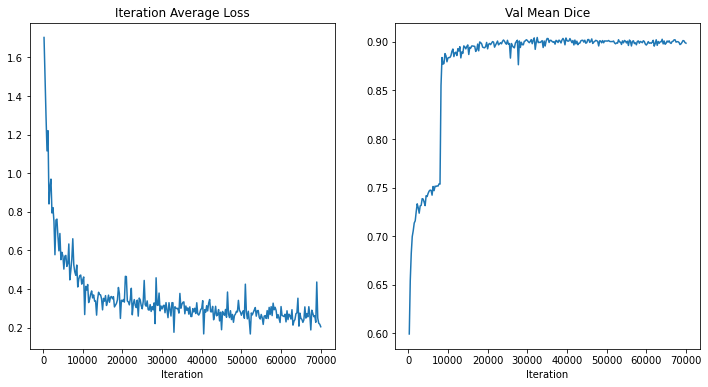

In [11]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

### Check best model output with the input image and label

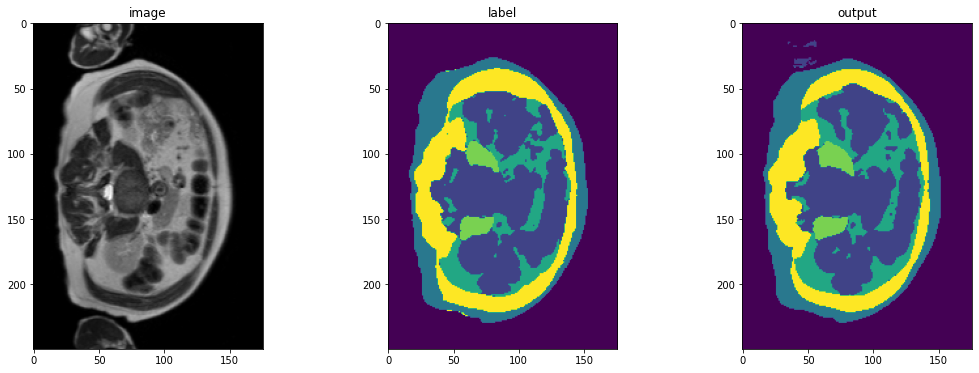

In [12]:
case_num = 0
model.load_state_dict(torch.load(os.path.join(data_dir, "TestMR10_swinUNetR_fold4.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).to(device)
    val_labels = torch.unsqueeze(label, 1).to(device)
    val_outputs = sliding_window_inference(
        val_inputs, (96, 96, 96), 4, model, overlap=0.8
    )
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, 5], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, 5])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(
        torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 5]
    )
    plt.show()
    

### Inference on test images

In [45]:
import glob
from monai.data import Dataset
from monai.handlers.utils import from_engine
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
)

test_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTs", "*.nii.gz")))

test_data = [{"image": image} for image in test_images]


test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(
            1.5, 1.5, 1.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=200,
            b_min=0.0, b_max=1.0, clip=False,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
        EnsureTyped(keys="image"),
    ]
)

test_org_ds = Dataset(
    data=test_data, transform=test_org_transforms)

test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose([
    EnsureTyped(keys="pred"),
    Invertd(
        keys="pred",
        transform=test_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=6),
    SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./outMR10swinfold4", output_postfix="seg", resample=False, separate_folder=False),
])

Modifying image pixdim from [1.4648438 1.4648438 8.        0.       ] to [  1.46484375   1.46484375   8.         281.03604124]


2024-01-16 10:26:27,151 INFO image_writer.py:194 - writing: outMR07_Jan24/A043_v5_T2W_seg.nii.gz


Modifying image pixdim from [1.4648438 1.4648438 8.        0.       ] to [  1.46484375   1.46484375   8.         281.03604124]


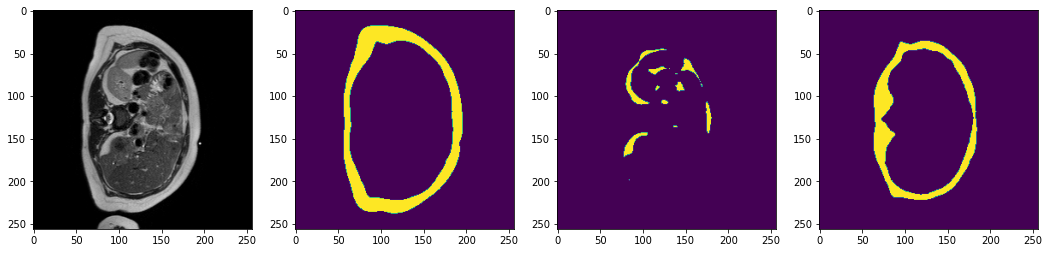

In [47]:
from monai.transforms import LoadImage
loader = LoadImage()

model.load_state_dict(torch.load(
    os.path.join(data_dir, "TestMR10_swinUNetR_fold4.pth")))
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (96, 96, 96)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(
            test_inputs, roi_size, sw_batch_size, model, overlap=0.8)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]

#         # uncomment the following lines to visualize the predicted results
        test_output = from_engine(["pred"])(test_data)

        original_image = loader(test_data[0]["image_meta_dict"]["filename_or_obj"])[0]

        plt.figure("check", (18, 6))
        plt.subplot(1, 4, 1)
        plt.imshow(original_image[:, :, 8], cmap="gray")
        plt.subplot(1, 4, 2)
        plt.imshow(test_output[0].detach().cpu()[2, :, :, 8])
        plt.subplot(1, 4, 3)
        plt.imshow(test_output[0].detach().cpu()[3, :, :, 8])
        plt.subplot(1, 4, 4)
        plt.imshow(test_output[0].detach().cpu()[5, :, :, 8])
        plt.show()

In [48]:
!tar -cvzf outMR10swinfold4.tar.gz outMR10swinfold4

outMR07_Jan24/
outMR07_Jan24/A026_v1_T2W_seg.nii.gz
outMR07_Jan24/A033_v3_T2W_seg.nii.gz
outMR07_Jan24/A043_v5_T2W_seg.nii.gz
outMR07_Jan24/A051_v2_T2W_seg.nii.gz
outMR07_Jan24/A009_v4_T2W_seg.nii.gz
outMR07_Jan24/A002_v3_T2W_seg.nii.gz
outMR07_Jan24/A029_v4_T2W_seg.nii.gz
outMR07_Jan24/.ipynb_checkpoints/
